# K-Mediods Clustering Algorithms

## 📌 Project Overview

This project compares **custom** and **Scikit-learn** implementations of **K-Medoids clustering** on three diverse datasets:

- **Iris Dataset**: A classic classification dataset containing 3 flower species.
- **AI Global Index**: A dataset with a mix of numerical and categorical features, reflecting global AI development.
- **Global Earthquake Data**: A complex geographical dataset tracking seismic activity worldwide.

### 🧪 Clustering Performance Evaluation

We evaluate the clustering results using the following metrics:

- **Silhouette Score**
- **Davies-Bouldin Index**
- **Calinski-Harabasz Index**
- **Adjusted Rand Score**
- **Adjusted Mutual Information Score**
- **Mutual Information Score**

---

## 1️⃣ Data Preparation & Preprocessing

In [15]:
# Core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Clustering & Distance Metrics
from sklearn.metrics import pairwise_distances
from pyclustering.cluster.kmedoids import kmedoids
from pyclustering.utils.metric import type_metric, distance_metric

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import MDS  # For dimensionality reduction

# Evaluation Metrics
from sklearn.metrics import (
    silhouette_score, adjusted_rand_score, 
    davies_bouldin_score, calinski_harabasz_score,
    adjusted_mutual_info_score, mutual_info_score
)

In [16]:
# Create the results directory if it doesn't exist
results_directory = "./../results"
if not os.path.exists(results_directory):
    os.makedirs(results_directory)
    
dataset_path = "./../datasets"

iris_dataset_path = dataset_path + "/iris.csv"                                         
ai_global_index_path = dataset_path + "/AI_index_db.csv"
global_earthquake_data_path = dataset_path + "/earthquakes.csv"


## Custom K-Medoids Implementation

In [17]:
# Custom K-Medoids Implementation
class CustomKMedoids:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4, random_state=None):
        """
        Initialize K-Medoids clustering.

        Parameters:
        - num_clusters: Number of clusters (default: 3).
        - max_iterations: Maximum number of iterations (default: 100).
        - tolerance: Tolerance for convergence (default: 1e-4).
        """
        self.num_clusters = n_clusters
        self.max_iterations = max_iter
        self.tolerance = tol
        self.medoids = None
        self.cluster_labels = None
        self.random_state = random_state

    def fit(self, data):
        np.random.seed(self.random_state)  
        """
        Fit the K-Medoids algorithm to the dataset.

        Parameters:
        - data: Input data (numpy array or pandas DataFrame).
        """

        num_samples, num_features = data.shape

        # Step 1: Randomly initialize medoids
        self.medoids = data[np.random.choice(num_samples, self.num_clusters, replace=False)]

        # Initialize total cost
        total_cost = self._calculate_total_cost(data, self.medoids)

        for iteration in range(self.max_iterations):
            # Step 2: Assign each point to the nearest medoid
            distances = pairwise_distances(data, self.medoids)
            self.cluster_labels = np.argmin(distances, axis=1)

            # Step 3: Update medoids
            new_medoids = self.medoids.copy()
            for medoid_index in range(self.num_clusters):
                # Get points assigned to the current medoid
                cluster_points = data[self.cluster_labels == medoid_index]

                # Compute the cost of swapping the medoid with each non-medoid point
                min_cost = np.inf
                best_candidate = None

                for candidate_index in range(len(cluster_points)):
                    # Swap medoid with candidate
                    candidate = cluster_points[candidate_index]
                    temp_medoids = new_medoids.copy()
                    temp_medoids[medoid_index] = candidate

                    # Compute new total cost
                    new_cost = self._calculate_total_cost(data, temp_medoids)

                    # Update if the new cost is better
                    if new_cost < min_cost:
                        min_cost = new_cost
                        best_candidate = candidate

                # Update medoid if a better candidate is found
                if best_candidate is not None:
                    new_medoids[medoid_index] = best_candidate

            # Step 4: Check for convergence
            new_total_cost = self._calculate_total_cost(data, new_medoids)
            if abs(total_cost - new_total_cost) < self.tolerance:
                break

            # Update medoids and total cost
            self.medoids = new_medoids
            total_cost = new_total_cost

    def _calculate_total_cost(self, data, medoids):
        """
        Compute the total cost of the current medoids.

        Parameters:
        - data: Input data.
        - medoids: Current medoids.

        Returns:
        - Total cost (sum of distances to the nearest medoid).
        """
        distances = pairwise_distances(data, medoids)
        return np.sum(np.min(distances, axis=1))

    def predict(self, data):
        """
        Predict the closest cluster for each sample in the data.

        Parameters:
        - data: Input data.

        Returns:
        - Cluster labels.
        """
        distances = pairwise_distances(data, self.medoids)
        return np.argmin(distances, axis=1)


## Evaluation Metrics

In [18]:
def evaluate_clustering(X, predicted_labels, true_labels=None):
    unique_labels = np.unique(predicted_labels)
    
    if len(unique_labels) < 2:
        # Invalid clustering result
        return {
            "silhouette_score": -1,
            "davies_bouldin_score": float("inf"),
            "calinski_harabasz_score": -1,
            "adjusted_rand_score": -1,
            "adjusted_mutual_info_score": -1,
            "mutual_info_score": -1
        }

    scores = {
        "silhouette_score": silhouette_score(X, predicted_labels),
        "davies_bouldin_score": davies_bouldin_score(X, predicted_labels),
        "calinski_harabasz_score": calinski_harabasz_score(X, predicted_labels),
    }

    
    if true_labels is not None:
        
        scores["adjusted_rand_score"] = adjusted_rand_score(true_labels, predicted_labels)
        scores["adjusted_mutual_info_score"] = adjusted_mutual_info_score(true_labels, predicted_labels)
        scores["mutual_info_score"] = mutual_info_score(true_labels, predicted_labels)
    else:
        scores["adjusted_rand_score"] = -1
        scores["adjusted_mutual_info_score"] = -1
        scores["mutual_info_score"] = -1

    return scores

## Mixed Data Dissimilarity Handling

In [19]:
class MixedDataDissimilarity:
    def __init__(self, numeric_cols, categorical_cols):
        self.numeric_cols = numeric_cols
        self.categorical_cols = categorical_cols
        self.min_vals = {}
        self.max_vals = {}

    def fit(self, df):
        """Compute and store min-max values for numeric columns."""
        for col in self.numeric_cols:
            self.min_vals[col] = df[col].min()
            self.max_vals[col] = df[col].max()
            if self.max_vals[col] == self.min_vals[col]:  # Avoid division by zero
                self.max_vals[col] += 1e-9

    def _compute_dissimilarity(self, row1, row2):
        """Compute dissimilarity between two rows."""
        num_diff = 0.0
        for col in self.numeric_cols:
            norm_i = (row1[col] - self.min_vals[col]) / (self.max_vals[col] - self.min_vals[col])
            norm_j = (row2[col] - self.min_vals[col]) / (self.max_vals[col] - self.min_vals[col])
            num_diff += abs(norm_i - norm_j)

        cat_diff = 0.0
        for col in self.categorical_cols:
            cat_diff += 0 if row1[col] == row2[col] else 1

        total_attrs = len(self.numeric_cols) + len(self.categorical_cols)
        return (num_diff + cat_diff) / total_attrs

    def transform(self, df):
        """Compute the full pairwise dissimilarity matrix."""
        n = len(df)
        dist_matrix = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):
                diff = self._compute_dissimilarity(df.iloc[i], df.iloc[j])
                dist_matrix[i, j] = diff
                dist_matrix[j, i] = diff  # symmetric
        return dist_matrix

    def fit_transform(self, df):
        """Fit and compute the dissimilarity matrix in one step."""
        self.fit(df)
        return self.transform(df)


## Experiments and Results


Processing iris dataset

Best K for iris: 2

Custom K-Medoids Metrics:
Silhouette Score: 0.5802, Davies-Bouldin Index: 0.5976, Calinski-Harabasz Index: 248.9034, Adjusted Rand Score: 0.5681, Adjusted MI Score: 0.7316, Mutual Info Score: 0.6365

PyClustering K-Medoids Metrics:
Silhouette Score: 0.5802, Davies-Bouldin Index: 0.5976, Calinski-Harabasz Index: 248.9034, Adjusted Rand Score: 0.5681, Adjusted MI Score: 0.7316, Mutual Info Score: 0.6365


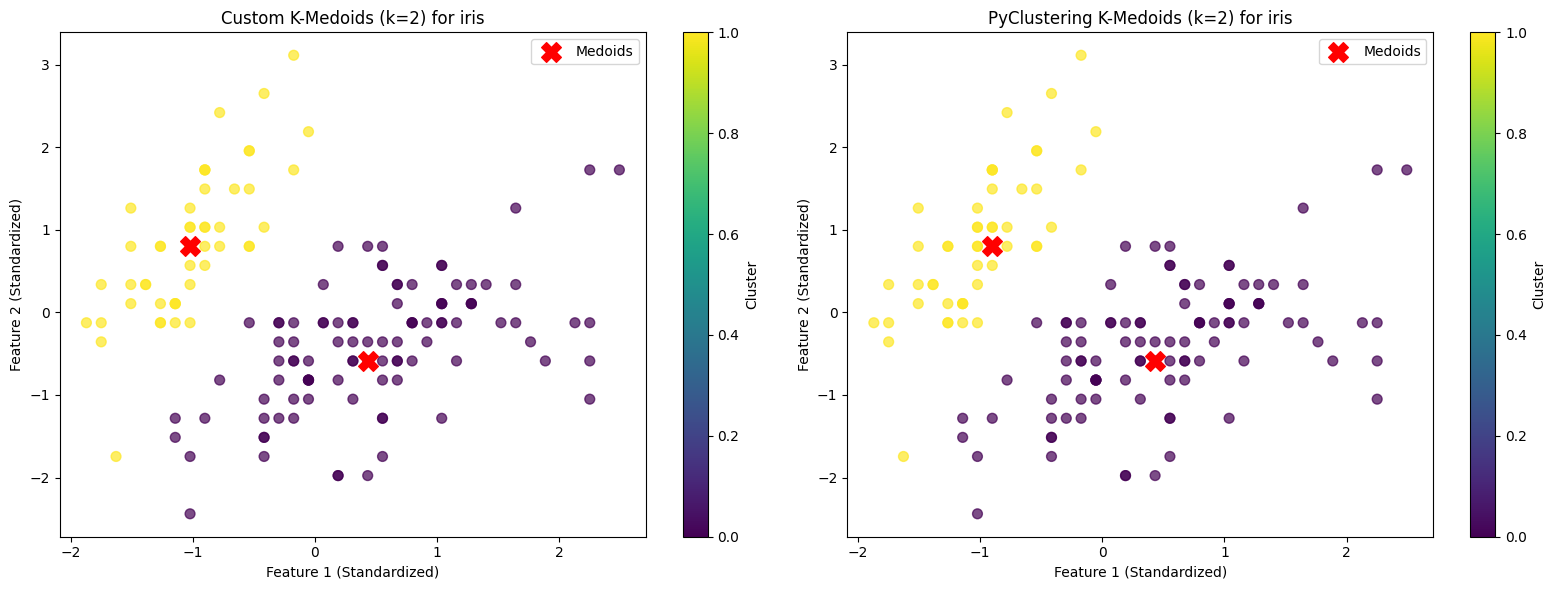


Processing ai_global_index dataset

Best K for ai_global_index: 2

Custom K-Medoids Metrics:
Silhouette Score: 0.4619, Davies-Bouldin Index: 0.9046, Calinski-Harabasz Index: 50.2449, Adjusted Rand Score: -0.0053, Adjusted MI Score: 0.0733, Mutual Info Score: 0.0994

PyClustering K-Medoids Metrics:
Silhouette Score: 0.4650, Davies-Bouldin Index: 0.9194, Calinski-Harabasz Index: 50.9064, Adjusted Rand Score: 0.0193, Adjusted MI Score: 0.1323, Mutual Info Score: 0.1489


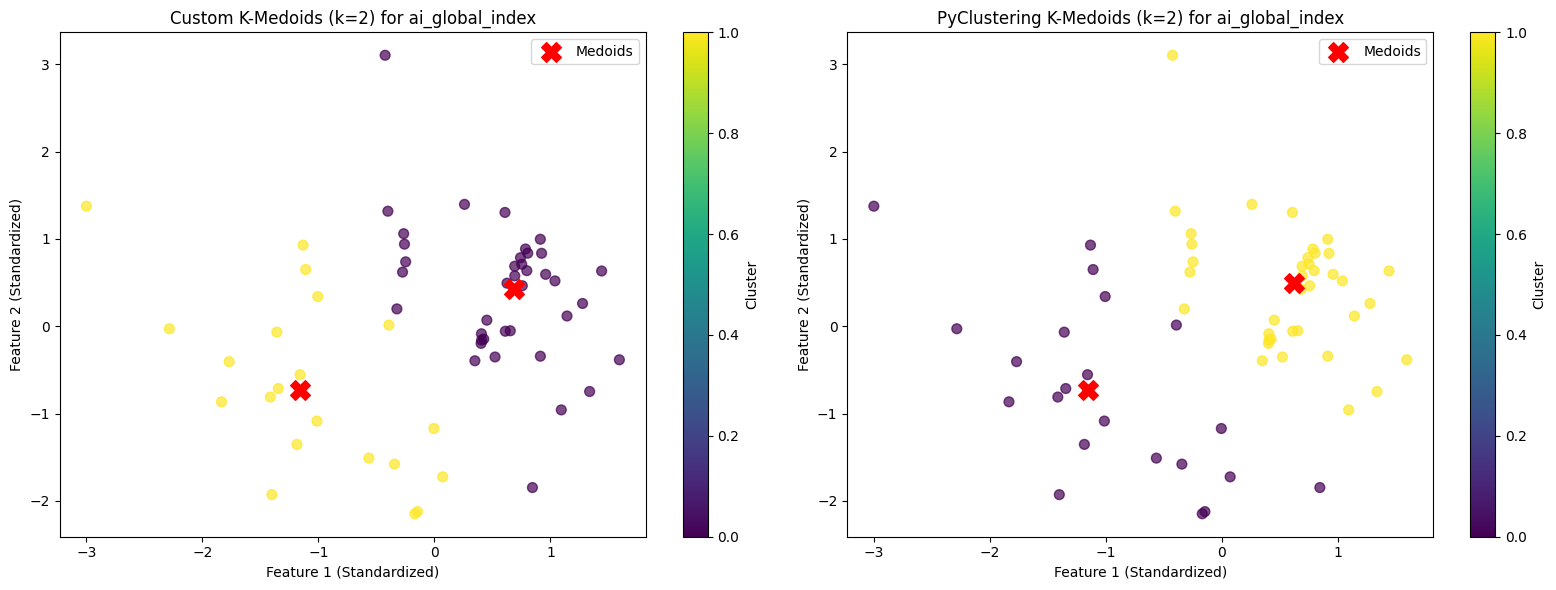


Processing global_earthquake dataset

Best K for global_earthquake: 5

Custom K-Medoids Metrics:
Silhouette Score: 0.2208, Davies-Bouldin Index: 1.4734, Calinski-Harabasz Index: 10.8706, Adjusted Rand Score: -1.0000, Adjusted MI Score: -1.0000, Mutual Info Score: -1.0000

PyClustering K-Medoids Metrics:
Silhouette Score: 0.1784, Davies-Bouldin Index: 1.6712, Calinski-Harabasz Index: 10.1210, Adjusted Rand Score: -1.0000, Adjusted MI Score: -1.0000, Mutual Info Score: -1.0000


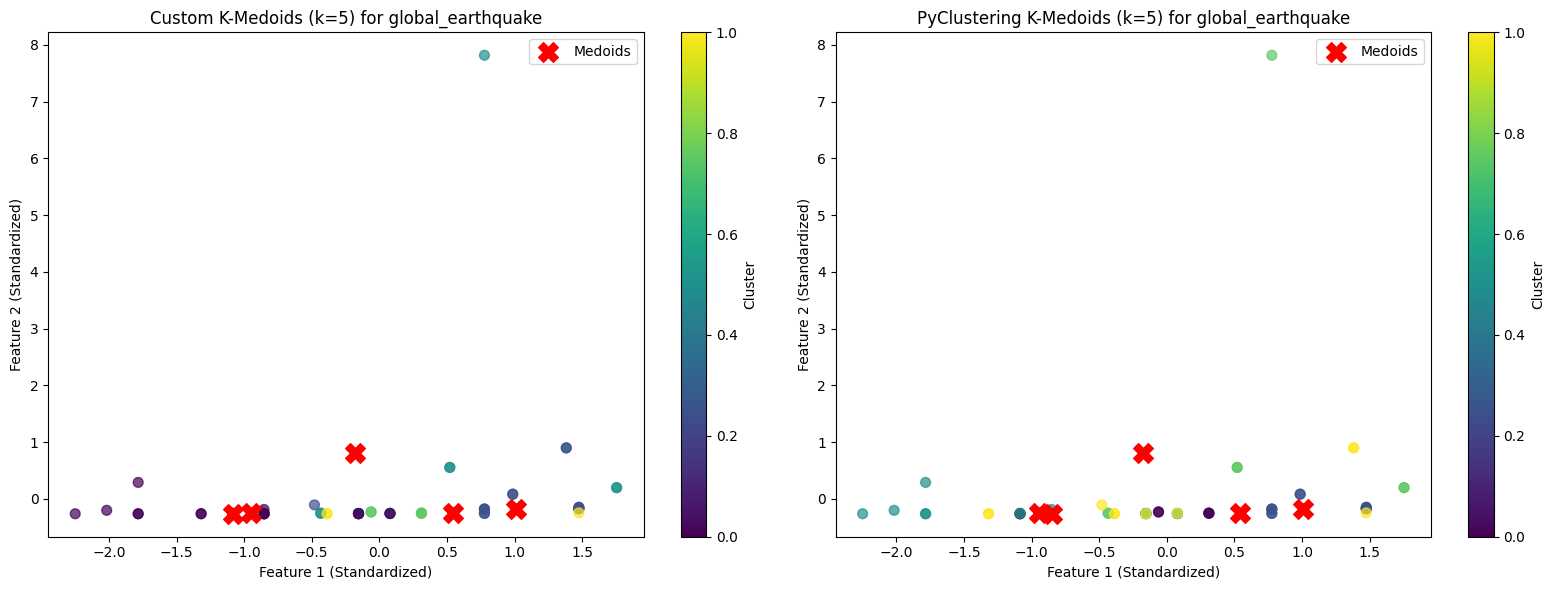

In [20]:
results = {}
k_range = range(2, 6)  # Try k values from 2 to 5

for name, (original_df, true_labels) in datasets.items():
    print(f"\nProcessing {name} dataset")
    df = original_df.dropna()
    
    if name == "ai_global_index":
        numeric_cols = [
            "Talent", "Infrastructure", "Operating Environment", 
            "Research", "Development", "Government Strategy", 
            "Commercial", "Total score"
        ]
        categorical_cols = ["Income group", "Political regime", "Region"]

        # Compute dissimilarity matrix
        dissim = MixedDataDissimilarity(numeric_cols, categorical_cols)
        dist_matrix = dissim.fit_transform(df)

        # Convert dissimilarity matrix to embedding for clustering
        mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42)
        X = mds.fit_transform(dist_matrix)
    else:
        # For datasets that are purely numerical
        X = df.select_dtypes(include=[np.number]).values

    # Normalize the data
    X = StandardScaler().fit_transform(X)

    best_k = None
    best_silhouette = -1
    k_results = {}

    for k in k_range:
        # Custom KMedoids
        custom_kmedoids = CustomKMedoids(n_clusters=k, max_iter=100, tol=1e-4, random_state=42)
        custom_kmedoids.fit(X)
        custom_labels = custom_kmedoids.predict(X)
        
        # PyClustering KMedoids
        # Initialize random medoids
        initial_medoids = np.random.choice(X.shape[0], k, replace=False)
        # Create metric (Euclidean by default)
        metric = distance_metric(type_metric.EUCLIDEAN)
        # Create K-Medoids instance
        pyclustering_kmedoids = kmedoids(X, initial_medoids, metric=metric,random_state=42 ,ccore=False,)
        # Run cluster analysis
        pyclustering_kmedoids.process()
        # Get results
        pyclustering_medoids = pyclustering_kmedoids.get_medoids()
        pyclustering_labels = np.zeros(X.shape[0])
        for cluster_idx, cluster in enumerate(pyclustering_kmedoids.get_clusters()):
            pyclustering_labels[cluster] = cluster_idx
        
        # Evaluate both
        custom_metrics = evaluate_clustering(X, custom_labels, true_labels=true_labels)
        pyclustering_metrics = evaluate_clustering(X, pyclustering_labels, true_labels=true_labels)

        # Save results
        k_results[k] = {
            "custom": {
                "silhouette": custom_metrics['silhouette_score'],
                "davies_bouldin": custom_metrics['davies_bouldin_score'],
                "calinski_harabasz": custom_metrics['calinski_harabasz_score'],
                "adjusted_rand_score": custom_metrics['adjusted_rand_score'],
                "adjusted_mutual_info_score": custom_metrics['adjusted_mutual_info_score'],
                "mutual_info_score": custom_metrics['mutual_info_score'],
                "labels": custom_labels,
                "medoids": custom_kmedoids.medoids
            },
            "pyclustering": {
                "silhouette": pyclustering_metrics['silhouette_score'],
                "davies_bouldin": pyclustering_metrics['davies_bouldin_score'],
                "calinski_harabasz": pyclustering_metrics['calinski_harabasz_score'],
                "adjusted_rand_score": pyclustering_metrics['adjusted_rand_score'],
                "adjusted_mutual_info_score": pyclustering_metrics['adjusted_mutual_info_score'],
                "mutual_info_score": pyclustering_metrics['mutual_info_score'],
                "labels": pyclustering_labels,
                "medoids": X[pyclustering_medoids]  # Convert indices to actual points
            }
        }

        # Track best silhouette
        if custom_metrics['silhouette_score'] > best_silhouette:
            best_silhouette = custom_metrics['silhouette_score']
            best_k = k

    # Store final result
    results[name] = {
        "best_k": best_k,
        "best_metrics": k_results[best_k]
    }

    # Print results
    print(f"\nBest K for {name}: {best_k}")
    
    print("\nCustom K-Medoids Metrics:")
    print(f"Silhouette Score: {k_results[best_k]['custom']['silhouette']:.4f}, "
          f"Davies-Bouldin Index: {k_results[best_k]['custom']['davies_bouldin']:.4f}, "
          f"Calinski-Harabasz Index: {k_results[best_k]['custom']['calinski_harabasz']:.4f}, "
          f"Adjusted Rand Score: {k_results[best_k]['custom']['adjusted_rand_score']:.4f}, "
          f"Adjusted MI Score: {k_results[best_k]['custom']['adjusted_mutual_info_score']:.4f}, "
          f"Mutual Info Score: {k_results[best_k]['custom']['mutual_info_score']:.4f}")
    
    print("\nPyClustering K-Medoids Metrics:")
    print(f"Silhouette Score: {k_results[best_k]['pyclustering']['silhouette']:.4f}, "
          f"Davies-Bouldin Index: {k_results[best_k]['pyclustering']['davies_bouldin']:.4f}, "
          f"Calinski-Harabasz Index: {k_results[best_k]['pyclustering']['calinski_harabasz']:.4f}, "
          f"Adjusted Rand Score: {k_results[best_k]['pyclustering']['adjusted_rand_score']:.4f}, "
          f"Adjusted MI Score: {k_results[best_k]['pyclustering']['adjusted_mutual_info_score']:.4f}, "
          f"Mutual Info Score: {k_results[best_k]['pyclustering']['mutual_info_score']:.4f}")

    # Plotting
    plt.figure(figsize=(16, 6))
    
    # Custom K-Medoids plot
    plt.subplot(1, 2, 1)
    plt.scatter(X[:, 0], X[:, 1], c=k_results[best_k]['custom']['labels'], cmap="viridis", s=50, alpha=0.7)
    plt.scatter(k_results[best_k]['custom']['medoids'][:, 0], 
                k_results[best_k]['custom']['medoids'][:, 1],
                c="red", marker="X", s=200, label="Medoids")
    plt.title(f"Custom K-Medoids (k={best_k}) for {name}")
    plt.xlabel("Feature 1 (Standardized)")
    plt.ylabel("Feature 2 (Standardized)")
    plt.legend()
    plt.colorbar(label="Cluster")

    # PyClustering K-Medoids plot
    plt.subplot(1, 2, 2)
    plt.scatter(X[:, 0], X[:, 1], c=k_results[best_k]['pyclustering']['labels'], cmap="viridis", s=50, alpha=0.7)
    plt.scatter(k_results[best_k]['pyclustering']['medoids'][:, 0], 
                k_results[best_k]['pyclustering']['medoids'][:, 1],
                c="red", marker="X", s=200, label="Medoids")
    plt.title(f"PyClustering K-Medoids (k={best_k}) for {name}")
    plt.xlabel("Feature 1 (Standardized)")
    plt.ylabel("Feature 2 (Standardized)")
    plt.legend()
    plt.colorbar(label="Cluster")

    plt.tight_layout()
    plt.show()

In [23]:
# Initialize dictionary to store summary metrics
summary = {
    'metric': [],
    'iris_custom': [],
    'iris_pyclustering': [],
    'ai_global_index_custom': [],
    'ai_global_index_pyclustering': [],
    'global_earthquake_custom': [],
    'global_earthquake_pyclustering': []
}

# Helper function to safely extract metrics
def get_metric(dataset_name, impl, metric_name):
    try:
        return results[dataset_name]["best_metrics"][impl][metric_name]
    except KeyError:
        return None  # Handle missing metrics gracefully

# List of metrics to collect (excluding mutual_info if not needed)
metrics = [
    'silhouette',
    'davies_bouldin', 
    'calinski_harabasz',
    'adjusted_rand_score',
    'adjusted_mutual_info_score'
]

# Collect all metrics
for metric in metrics:
    summary['metric'].append(metric)
    
    for dataset in ['iris', 'ai_global_index', 'global_earthquake']:
        # Custom implementation
        val = get_metric(dataset, 'custom', metric)
        summary[f'{dataset}_custom'].append(val)
        
        # PyClustering implementation
        val = get_metric(dataset, 'pyclustering', metric) 
        summary[f'{dataset}_pyclustering'].append(val)

# Convert to DataFrame and save
results_df = pd.DataFrame(summary)
results_df.to_csv("./../results/kmedoids_results.csv", index=False)
print("Results saved successfully!")

Results saved successfully!
